In [ ]:
import ase
from ase.io import read
import numpy as np

In [ ]:
import sys

sys.tracebacklimit = None

# Utilities

In [ ]:
def handle_PBC(
    ng: int,
    g: int,
    n: int,
    R: int,
    coords_j: np.ndarray,
    v: np.ndarray,
) -> tuple[np.ndarray, int]:
    """Adjust atom coordinates w.r.t the periodic boundary
    conditions in the supplied direction.

    Parameters
    ----------
    `ng` : `int`
        number of grid cells in a given direction
    `g` : `int`
        index of grid cell in a given direction
    `n` : `int`
        index of neighboring grid cell in a given direction
    `R` : `int`
        R vector component in a given direction
    `coords_j` : `np.ndarray`
        coordinates of atom j
    `v` : `np.ndarray`
        lattice vector in a given direction

    Returns
    -------
    `tuple[np.ndarray, int]`
        adjusted coordinates of atom j and R vector component
    """
    if g == 0 and g + n < g and (g + n) % ng == ng - 1:
        R -= 1
        coords_j = coords_j - v
    elif g == ng - 1 and g + n > g and (g + n) % ng == 0:
        R += 1
        coords_j = coords_j + v
    return coords_j, R

# Define structure

In [ ]:
filename = ""  # local POSCAR file

try:
    poscar = read(filename, format="vasp")
except FileNotFoundError as err:
    raise FileNotFoundError(f"File {filename} not found") from err


super_cell = poscar.repeat((1, 1, 1))

# sort by x, then by y
super_cell = super_cell[
    np.lexsort(
        (
            super_cell.positions[:, 0],
            super_cell.positions[:, 1],
            super_cell.positions[:, 2],
        )
    )
]

super_cell.write("non_standard_BLG_AB_supercell.vasp", format="vasp")

natoms = len(super_cell)
nlayers = 2
natoms_per_layer = natoms // nlayers
a, b, c = super_cell.cell.lengths()
a_vec, b_vec, c_vec = super_cell.cell.array
inter_layer_height = 0.5 * c

# Define search grid

In [ ]:
# define nearest neighbor distances
distances = (0.0, 1.425, 2.468, 2.850)

search_distance = distances[1]  # don't use 0!
if search_distance == 0:
    raise ValueError("search distance is zero; use distances index > 0")

# calculate the number of grid squares in each dimension
ngx = int(np.ceil(a / search_distance)) - 1
ngy = int(np.ceil(b / search_distance)) - 1
ngx = 1 if ngx == 0 else ngx
ngy = 1 if ngy == 0 else ngy

# calculate adjusted grid cell size in each dimension to perfectly fit the cell
gxs = a / ngx  # grid cell size in x
gys = b / ngy  # grid cell size in y

# create the grid, separated by layers
grid = [[[] for _ in range(ngx)] for _ in range(ngy)]

# assign atoms to grid cells
atom: ase.Atom
for ai, atom in enumerate(super_cell):
    x, y, z = atom.position
    gx = int(x / gxs)
    gy = int(y / gys)
    grid[gy][gx].append(ai)

# Compute H

In [ ]:
from scipy.sparse import lil_matrix

from potentials import PotentialFactory

potential = PotentialFactory("kronig-penney")
potential.amplitude = 1.0

hopping_parameters = (0.0, -2.7, -0.8, -0.027)  # replace these
interlayer_coupling = 0.33
interlayer_alpha = (1.0, 0.5)
threshold = search_distance + 0.1

R = [np.array([j, i, 0]) for i in range(-1, 2) for j in range(-1, 2)]
H = [lil_matrix((natoms, natoms)) for _ in range(len(R))]

R_index_map = {
    (-1, -1): 0,
    (0, -1): 1,
    (1, -1): 2,
    (-1, 0): 3,
    (0, 0): 4,
    (1, 0): 5,
    (-1, 1): 6,
    (0, 1): 7,
    (1, 1): 8,
}

In [ ]:
for gy in range(ngy):
    for gx in range(ngx):
        # consider only first nearest neighboring grid cells
        for ny in range(-1, 2):
            for nx in range(-1, 2):
                # loop over atoms in the current grid cell
                for ai in grid[gy][gx]:
                    # define local grid indices
                    lgy = (gy + ny) % ngy  # wrap around cell
                    lgx = (gx + nx) % ngx  # wrap around cell

                    # loop over atoms in the neighboring grid cell
                    for aj in grid[lgy][lgx]:
                        # H is symmetric, so we compute
                        # only the upper triangular matrix
                        if ai <= aj:
                            coords_i = super_cell.positions[ai]
                            coords_j = super_cell.positions[aj]

                            # used later to derive the R index of H
                            Rx, Ry = 0, 0

                            if nx != 0:
                                # handle boundary conditions in the x
                                coords_j, Rx = handle_PBC(
                                    ngx, gx, nx, Rx, coords_j, a_vec
                                )

                            if ny != 0:
                                # handle boundary conditions in the y
                                coords_j, Ry = handle_PBC(
                                    ngy, gy, ny, Ry, coords_j, b_vec
                                )

                            v = coords_i - coords_j  # displacement vector

                            # update H with hopping parameters
                            # if ai-aj distance is within threshold
                            d = np.round(np.abs(np.linalg.norm(v)), 3)
                            if d < threshold:
                                # pick hopping parameter based on distance
                                for i, distance in enumerate(distances):
                                    if np.isclose(d, distance):
                                        hp = hopping_parameters[i]
                                        break

                                # on-site, i.e., ai == aj
                                if i == 0:
                                    frac_i = super_cell.get_scaled_positions()[ai]
                                    j = 0 if frac_i[2] < 0.5 else 1
                                    alpha = interlayer_alpha[j]
                                    hp += alpha * potential(frac_i)

                                Ri = R_index_map[(Rx, Ry)]
                                H[Ri][ai, aj] = hp

                                if i > 0:
                                    Ri = R_index_map[(-Rx, -Ry)]
                                    H[Ri][aj, ai] = hp

                            # update H with interlayer coupling
                            if (
                                np.isclose(v[0], 0)
                                and np.isclose(v[1], 0)
                                and not np.isclose(v[2], 0)
                            ):
                                Ri = R_index_map[(0, 0)]
                                H[Ri][ai, aj] = H[Ri][aj, ai] = interlayer_coupling

# Write H to file

In [ ]:
from collections import OrderedDict

neighbor_count = OrderedDict.fromkeys(range(1, natoms + 1), 0)
onsite_count = 0

with open("hamiltonian.dat", "w") as f:
    # write banner

    # write H
    for i, r in enumerate(R):
        Hcoo = H[i].tocoo()
        for ai, aj, v in zip(Hcoo.row, Hcoo.col, Hcoo.data):
            if ai != aj:
                neighbor_count[int(ai + 1)] += 1
            else:
                onsite_count += 1
            Rx, Ry, Rz = r
            f.write(f"{Rx:5d}{Ry:5d}{Rz:5d}{ai + 1:8d}{aj + 1:8d}{v:13.6f}{0:13.6f}\n")

# Sanity checks


Onsite count should be 0 or `natoms`

In [ ]:
# onsite_count

Atoms should have **3** <strong style="color: orange">1st</strong> + **6** <strong style="color: green">2nd</strong> + **3** <strong style="color: purple">3rd</strong> nearest neighbors + possibly **one** <strong style="color: red">intelayer</strong>, so **4/10/13** max

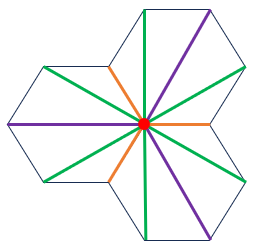


In [ ]:
# for atom, count in neighbor_count.items():
#     print(f'Atom {atom} has {count} neighbors')

# Plotting

In [ ]:
# %matplotlib widget

### Plot H

In [ ]:
# Hr = H[4].toarray()

In [ ]:
# import matplotlib.pyplot as plt

# start = 0
# end = start + natoms
# step = 10

# plt.figure(figsize=(5, 5))
# plt.imshow(Hr[start:end, start:end], cmap='inferno', interpolation='nearest')
# plt.xticks(np.arange(start, end - start, step), np.arange(start, end, step) + 1)
# plt.yticks(np.arange(start, end - start, step), np.arange(start, end, step) + 1)
# plt.colorbar()
# plt.show()

### Plot grid

In [ ]:
# # plot the grid
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(5, 5))
# for gi in range(ngx):
#     for gj in range(ngy):
#         ax.add_patch(
#             plt.Rectangle(
#                 (gi * gxs, gj * gys),
#                 gxs,
#                 gys,
#                 fill=None,
#                 edgecolor="black",
#             )
#         )
# ax.set_aspect("equal")
# ax.set_xlim(0, super_cell.cell.lengths()[0])
# ax.set_ylim(0, super_cell.cell.lengths()[1])
# ax.set_xticks(np.arange(0, super_cell.cell.lengths()[0], gxs))
# ax.set_yticks(np.arange(0, super_cell.cell.lengths()[1], gys))

# # plot the atoms
# atom: ase.Atom
# for atom in super_cell:
#     x, y, z = atom.position
#     if z < inter_layer_height:
#         ax.plot(x, y, "o", color="blue")
#         ax.text(x, y - 0.1, atom.index, fontsize=12, ha='center', va='center')
#     else:
#         ax.plot(x + 0.05, y, "o", color="red")
#         ax.text(x, y + 0.1, atom.index, fontsize=12, ha='center', va='center')

# plt.show()